In [3]:
# Ensure you have the necessary libraries installed before running the notebook
!pip install opencv-python-headless numpy scikit-learn tensorflow


In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [5]:
# Load a sample video for demonstration
video_path = 'sample_video.mp4'
cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()
num_frames = len(frames)
print(f"Total number of frames: {num_frames}")

Total number of frames: 601


In [6]:
# Utility function to display a sample of keyframes
def display_keyframes(keyframes, method_name):
    n = min(5, len(keyframes))
    sample_indices = np.linspace(0, len(keyframes) - 1, n, dtype=int)
    sample_frames = [keyframes[i] for i in sample_indices]
    
    plt.figure(figsize=(15, 5))
    for i, frame in enumerate(sample_frames):
        plt.subplot(1, n, i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f'{method_name} Keyframe {i}')
        plt.axis('off')
    plt.show()


Number of sampled frames: 21


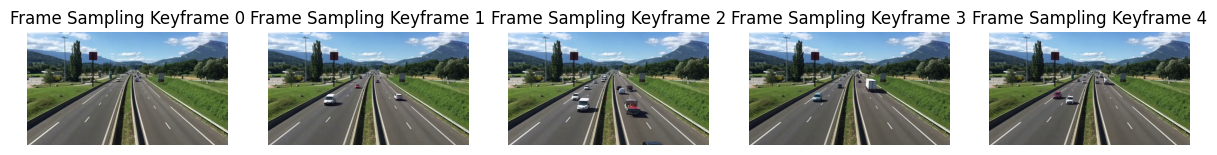

In [7]:
# Method 1: Frame Sampling
def frame_sampling(frames, interval):
    sampled_frames = frames[::interval]
    return sampled_frames

sampled_frames = frame_sampling(frames, interval=30)
print(f"Number of sampled frames: {len(sampled_frames)}")

display_keyframes(sampled_frames, "Frame Sampling")

Number of keyframes detected by scene change: 601


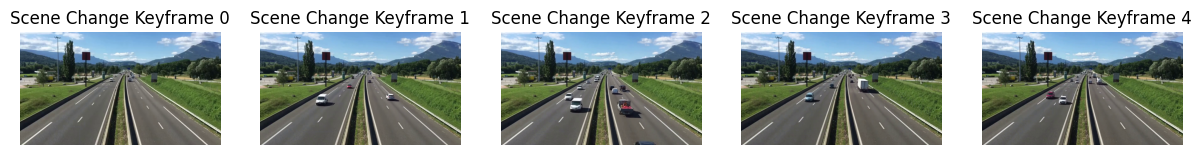

In [8]:

# Method 2: Scene Change Detection
def scene_change_detection(frames, threshold=0.5):
    keyframes = [frames[0]]
    prev_hist = cv2.calcHist([frames[0]], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
    for i in range(1, len(frames)):
        hist = cv2.calcHist([frames[i]], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
        diff = cv2.compareHist(prev_hist, hist, cv2.HISTCMP_CHISQR)
        if diff > threshold:
            keyframes.append(frames[i])
            prev_hist = hist
    return keyframes

keyframes_scene_change = scene_change_detection(frames, threshold=0.5)
print(f"Number of keyframes detected by scene change: {len(keyframes_scene_change)}")

display_keyframes(keyframes_scene_change, "Scene Change")

c:\Users\ajayr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of keyframes detected by clustering: 5


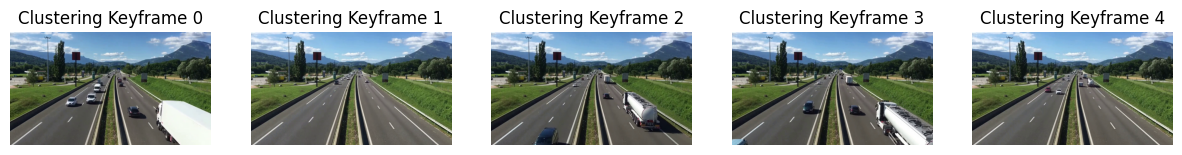

In [9]:
# Method 3: Clustering-based Keyframe Extraction
def clustering_keyframes(frames, num_clusters):
    frame_vectors = [cv2.resize(frame, (64, 64)).flatten() for frame in frames]
    kmeans = KMeans(n_clusters=num_clusters).fit(frame_vectors)
    cluster_centers = kmeans.cluster_centers_
    closest_indices = [np.argmin(np.linalg.norm(frame_vectors - center, axis=1)) for center in cluster_centers]
    keyframes = [frames[i] for i in closest_indices]
    return keyframes

keyframes_clustering = clustering_keyframes(frames, num_clusters=5)
print(f"Number of keyframes detected by clustering: {len(keyframes_clustering)}")

display_keyframes(keyframes_clustering, "Clustering")

1/1 [==============================] - 0s 139ms/step
Number of keyframes detected by deep learning: 480


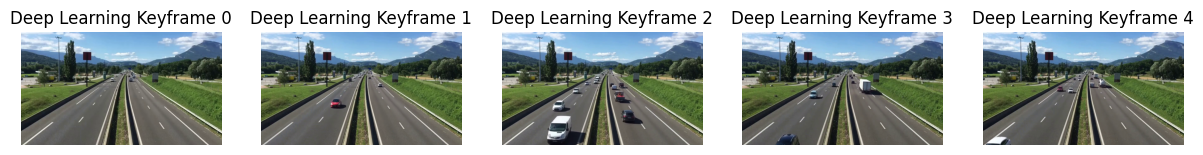

In [10]:


# Method 4: Deep Learning-based Keyframe Extraction
def deep_learning_keyframes(frames, model, threshold=0.8):
    features = [model.predict(preprocess_input(np.expand_dims(cv2.resize(frame, (224, 224)), axis=0))) for frame in frames]
    features = np.array(features).reshape(len(frames), -1)
    mean_feature = np.mean(features, axis=0)
    distances = np.linalg.norm(features - mean_feature, axis=1)
    keyframes = [frames[i] for i in np.where(distances > np.percentile(distances, 100 - threshold * 100))[0]]
    return keyframes

base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

keyframes_deep_learning = deep_learning_keyframes(frames, model, threshold=0.8)
print(f"Number of keyframes detected by deep learning: {len(keyframes_deep_learning)}")

display_keyframes(keyframes_deep_learning, "Deep Learning")
